<a href="https://colab.research.google.com/github/jarek-pawlowski/advanced-machine-learning/blob/main/mnist_in_3_flavours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of handwritten digits using various neural network models with PyTorch
* Multinomial classification task of images of handwritten digits (10 classes).
* The database has a training set of 60k examples, and a test set of 10k examples, each image is of 28x28 pixels size.
* The MNIST ("Modified National Institute of Standards and Technology") is the “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

## Model setup

Before we start we need to load libraries and setup the model parameters

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128 
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 50
# logging frequency
model_args['log_interval'] = 100

Let's start with loading the dataset and check how it looks like

In [10]:
# load the MINST dataset 
transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
test_subset = datasets.MNIST('../data', train=False, download=True, transform=transform)

# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 8, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

50000
10000
10000
391
torch.Size([28, 28])


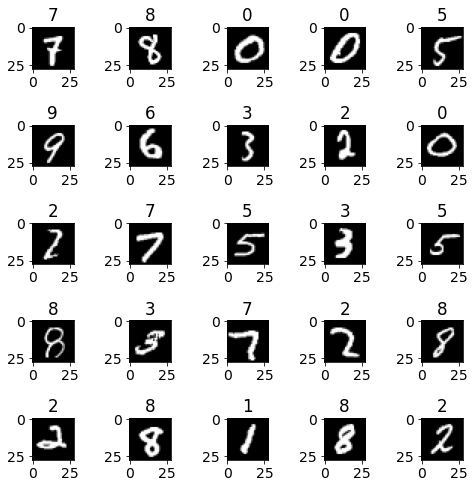

In [11]:
print(len(train_subset))
print(len(validation_subset))
print(len(test_subset)) # we have data already divided into train & validation & test subsets
print(len(train_loader)) # no of train batches
example_number = 123
print(train_subset[example_number][0][0].shape) # single item shape

fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(train_subset[example_number+i*5+j][0].reshape(28,28), cmap='gray')
        axs[i,j].set_title(train_subset[example_number+i*5+j][1])

Let's now construct the NN models:
- we start with siplest single layer **perceptron** with *softmax* activation,
- then test **deep** network with some (fully-connected) *hidden* layers,
- and finally setup deep **convolutional neural network**.

In [12]:
class Perceptron(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Perceptron, self).__init__()
        # fully connected layer
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

class Deep(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Deep, self).__init__()
        # fully connected layers
        self.fc1 = nn.Linear(28*28, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        # hidden layer
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

class CNN(nn.Module):
    # this defines the structure of the CNN model
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer with 2 kernels of size 5x5
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5) 
        # 4 kernels of size 5x5
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5)
        # 2D dropout
        self.conv2_drop = nn.Dropout2d()
        # fully connected layers
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        # 1st layers group
        x = self.conv1(x) # resulting in 4 feature maps each of size 24x24
        x = F.max_pool2d(x, 2) # downsizing each map to 12x12
        x = F.relu(x) # standard (in CNNs) ReLU activation
        # 2nd group
        x = self.conv2(x) # resulting in 18 feature maps each of size 8x8
        # x = self.conv2_drop(x) 
        x = F.max_pool2d(x, 2) # downsizing each map to 4x4
        x = F.relu(x)
        # fully connected layers
        x = x.view(-1, 64) # 4 maps of 4x4 size gives 64 numbers
        x = self.fc1(x) # 64 -> 20
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # dropout is a type of regularization
        x = self.fc2(x) # 20 -> 10
        # softmax (multinomial classification) gives probabilities of each class
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch


And define training, testing, and plotting utils:

In [13]:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean') 
            # get the index of class with the max log-probability 
            prediction = output.argmax(dim=1)  
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

## Experiments

1. At first let's test the single-layer *Perceptron* model



Train Epoch: 1 [0/50000 (0%)]	Loss: 2.509881
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.349456
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.317194
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.472229

Train set: Average loss: 0.3750
Validation set: Average loss: 0.3168, Accuracy: 9067/10000 (91%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.262654
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.340136
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.273379
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.187548

Train set: Average loss: 0.3028
Validation set: Average loss: 0.3071, Accuracy: 9102/10000 (91%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.249439
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.240138
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.305358
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.301732

Train set: Average loss: 0.2897
Validation set: Average loss: 0.2950, Accuracy: 9171/10000 (92%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.324195
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.268590
Train Epoch: 4 [25600/5

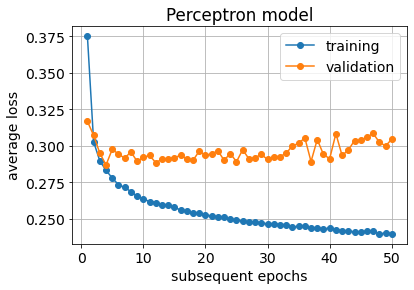

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Perceptron().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Perceptron model')

2. Now add a hidden layer to the *Perceptron* and evaluate the *Deep* model 

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.339325
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.371582
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.330278
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.382958

Train set: Average loss: 0.4120
Validation set: Average loss: 0.2750, Accuracy: 9161/10000 (92%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.222000
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.285781
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.232825
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.129902

Train set: Average loss: 0.2392
Validation set: Average loss: 0.2275, Accuracy: 9310/10000 (93%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.178048
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.200862
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.263302
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.181461

Train set: Average loss: 0.1973
Validation set: Average loss: 0.2054, Accuracy: 9423/10000 (94%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.199276
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.222078
Train Epoch: 4 [25600/5

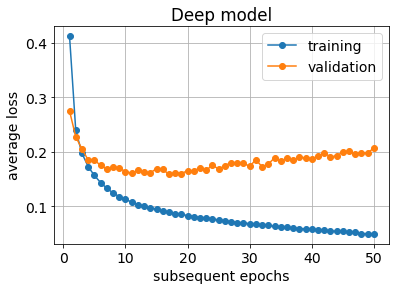

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Deep().to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'])
                      #weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep model')

3. Compare these results with a deep convolutional network, which is more useful in real-world problems:

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.295282
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.027023
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.030442
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.853013

Train set: Average loss: 1.0710
Validation set: Average loss: 0.2922, Accuracy: 9174/10000 (92%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.772529
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.677360
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.651219
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.595755

Train set: Average loss: 0.6599
Validation set: Average loss: 0.2534, Accuracy: 9209/10000 (92%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.669047
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.639756
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.632336
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.707314

Train set: Average loss: 0.5841
Validation set: Average loss: 0.2097, Accuracy: 9395/10000 (94%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.515649
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.482793
Train Epoch: 4 [25600/5

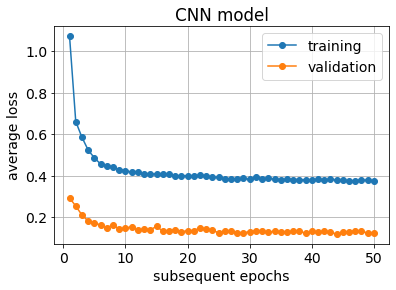

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'CNN model')

## Summary
* *Deep* and *CNN* models with accuracies of 96% and 97% (evaluated on the test subset) perform much better than single-layer *Perceptron* with 92%;
* The two smallest (and simplest) models appear to be overfitted. To deal with this we need to apply some regularization.
* Validation subset is evaluated during the training (as opposed to test set, infered *after* the training) in order to tune the model hiperparameters (that describe e.g. the network structure, or training details).
* A moment to stop trainning is a kind of hipermarameter -- by applying *early stopping* we can avoid overfitting.



## Tasks to do
* apply some regularization technique to *Deep* model in order to avoid overfitting (start with nonzero *weight_decay* in optimizer)
* try to figure out why the validation loss for *CNN* model turns to be *lower* than the train loss (hint: turn off regularization),
* **tune one of these models to get the *Test Set Accuracy* > 99%**,
* plot the *confusion matrix* among all of the classes---which of digits are mostly confused with each other?,
* and finally prepare report.

### How the report should look like
* 1-2 page long
* shortly describe what modifications you apply
* justyfy in a few words why your improved model is so cool
* results should be presented as plots with multiline captions